# Exploring ligand dissociation trajectories of GPCR complexes using pre-computed Protein-Ligand Interaction Fingerprints (IFPs)

## Protein-Ligand Interaction Fingerprints (IFPs) are used to detect metastable states in ligand dissociation pathways generated by the RAMD method (Random Acceleration Molecular Dynamics)

################################################################################################################
### Scripts were used for analysis reported in the manuscript
    "G-Protein Coupled Receptor-Ligand Dissociation Rates and Mechanisms from tauRAMD Simulations" 
     by Daria B. Kokh, Rebecca C. Wade
     submitte to JCTC , June 2021
################################################################################################################

### Scripts includes:

    1. Reading and cleaning PL IFP data generated from RAMD dissociation trajectories
    2. Clustering of all frames in dissociation trajectories by the PL IFP similarity (kmean )
         - Illustration of ligand dissociation pathways in a graph representation (Figs.3 B,C , Fig. 6A-C, Fig.S2,S3,S5,S6); 
         - mapping of generated clusters (metastable states) on 3D grid that can be then vizualized .
         - visualization of cluster composition
         - Identification of the snapshot in dissociation trajectories from IFP database
    3. Motion of the allosterinc ligand (PAM) in simulations of iperoxo dissiociation (Fig.5D)
    4. Exploring ligand solvation (data are available only for β2AR - β2-adrenergic receptor ; Fig.3H, S4) 
    5. Hierarchical clustering of the last P-L contact (or finding main egress routs) and Mapping of generated clusters on a 3D grid (*dx) that can be then vizualized using molecule vizualization software ( Fig.S7)


### Input data required:

    You will need IFP data frames generated for following systems: 
    1. mAChR M2 muscarinic receptor bound to 
        (i) iperoxo -IXO-CHL.zip
        (ii) iperoxo and PAM - IXO-ALO-CHL.zip
        (iii) ACh - ACh-CHL.zip
    2. β2AR - β2-adrenergic receptor bound to 
        alprenolol - b2AR.zip
        water.zip (only for the section 4)
    Data must be unpacked and copied into the directory ./DATA/GPCR-2020/
    and ./DATA/GPCR-09-2020/WATER/ (for water.zip)


### Packages required (version used for testing):
    numpy (v 1.18.1)
    matplotlib (3.1.3)
    sklearn (0.22.1)
    scipy (1.4.1)
    pandas (1.0.2)
    seaborn (0.10.0)
    code is written on Python 3.x and tested on the version 3.7
    
    Functions collected in the directory Scripts (Scripts.zip file)


### v 1.0
    02.06.2021
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Author: Daria Kokh
    daria.kokh@h-its.org or mcmsoft@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany

In [4]:
#from SetUp.trajectory_analysis import *
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [5]:
import glob, os
import sys
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
from matplotlib import cm
import matplotlib.ticker
from matplotlib import gridspec
import  pylab as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy as clust
from scipy.spatial.distance import pdist

import hashlib
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
#from kmodes.kmodes import KModes


In [6]:
from Scripts.Clustering import *


In [7]:
#import rdkit
#print( rdkit.__version__)

##  1. Read IFP data and prepare them for analysis


In [8]:
#
IFP_all =  ["AR","HD","HA","HY","WB","IP","IN","WB"]
IFP_RE =  ["RE"]
IFP_mixed =  ["AR","HD","HA","HY","WB","IP","IN","WB","RE"]

# naming: 
# "*SL-600-RAMD*.pkl"  - force 14 kcal/mol A
# "*FA-600-RAMD*.pkl"  - force 16 kcal/mol A
# "*EX-600-RAMD*.pkl"  - force 12 kcal/mol A
# "*SU-600-RAMD*.pkl"  - force 10 kcal/mol A
# "IXO-CHL"   - iperoxo
# "IXO-ALO"   - iperoxo _PAM
# "ACh-CHL"   - Ach

# choose simulation type
simulation_type = {"f16_":"*FA-700-RAMD*.pkl","f14_":"*SL-700-RAMD*.pkl","f12_":"*EX-700-RAMD*.pkl","f10_":"*SU-700-RAMD*.pkl",}


##  1.1 Define system and data location to be analyzed 

In [9]:
######################## Select the system to be analized
# define a Directory with the data
dir_all =  "DATA\\GPCR-09-2020\\"

noLIP = False
# Choose a system either mAChR M2 muscarinic receptor or β2AR - β2-adrenergic receptor 
M2 = False
AR = not M2
# choose data computed using a specific RAMD force 
version = "f12_" 
#############################

DIR_in = dir_all
if M2: 
    # choose a ligand:   
    #   "IXO-ALO" - iperoxo with PAM
    #   "IXO-CHL" - iperoxo
    #   "ACh-CHL" - Ach
    ligand ="IXO-ALO" 
    name_template = ligand+simulation_type[version] #"*SL-700-RAMD*.pkl"  "*FA-700-RAMD*.pkl"
    DIR_out = DIR_in+ligand+"-Results\\"
    if not os.path.exists(DIR_out): os.mkdir(DIR_out)
elif AR:
    ligand =  "b2AR" 
    name_template = ligand+simulation_type[version]   #"*EX-700-RAMD*.pkl"  "*SL-700-RAMD*.pkl"  "*FA-600-RAMD*.pkl"
    DIR_out = DIR_in+ligand+"-Results\\"
    if not os.path.exists(DIR_out): os.mkdir(DIR_out)
    

## 1.2 read IFP database for just one ligand

In [10]:
#---- read IFP data set: 
df_tot_org,ligandsi,directi = read_databases(DIR_in,name_template,name_len =50)
print(df_tot_org.shape)  
if df_tot_org.shape[0] == 0:
    print(" Files were not found !!!")
    sys.exit()
    
#---- sort resudues by number
resi_list_sorted,resi_name_list_sorted,ifp_list = separate_IFP(df_tot_org.columns.tolist())

try:
    if(np.unique(df_tot_org.Repl.values) == ''):
        Repl = []
        R = 0
        start = np.argwhere(df_tot_org.time.values == 0).flatten()
        for i in range(0,df_tot_org.shape[0]): 
            if i in start: R += 1
            Repl.append("Repl_"+str(R))
        df_tot_org.Repl = Repl
except:
    pass

File:  DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_02.pkl
----------  Name:  b2AR-unwtapped-WB-EX-700-RAMD_02.pkl
Trajectory length will be taken from DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_02.dat
[6.65, 4.816, 13.551]
File:  DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_03.pkl
----------  Name:  b2AR-unwtapped-WB-EX-700-RAMD_03.pkl
Trajectory length will be taken from DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_03.dat
[12.552, 10.37, 15.336, 7.359]
File:  DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_04.pkl
----------  Name:  b2AR-unwtapped-WB-EX-700-RAMD_04.pkl
Trajectory length will be taken from DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_04.dat
[18.829]
File:  DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_05.pkl
----------  Name:  b2AR-unwtapped-WB-EX-700-RAMD_05.pkl
Trajectory length will be taken from DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_05.dat
[4.903, 7.893, 11.764, 24.657]
File:  DATA\GPCR-09-2020\b2AR-unwtapped-WB-EX-700-RAMD_1.pkl
------

## 1.3 Check ligand RMSD 
##  discard trajectories where  ligand readily left the pocket at the beginning of the trajectory; ## comupte the number of dissociation  trajectories going through the membrane 
    egress routs through the membrane are defined as follows:
    - first frame  where less than 2 non-scpecific ligand-protein contact found
    - if ligand has contacts with more than 3 lipid in the first frame as ligand left the protein


(8,)
    too large ligand RMSD in the first frame :  47.8847885529794 86.576242735076
    too large protein RMSD (to be discarded):  10.268789445356054
    too small ligand RMSD at the end (to be discarded):  4.827390537179867 12.948703832403703
    too large protein RMSD (to be discarded):  10.984514516834784
0  LIPID interaction:  Repl_15 2  Lip sum: 11 Wat sum:  302 Lip max contacts:  11.0
0  LIPID interaction:  Repl_16 3  Lip sum: 6 Wat sum:  443 Lip max contacts:  13.0
    too large protein RMSD (to be discarded):  10.928749034837866
    too large protein RMSD (to be discarded):  10.007955277228465
0  LIPID interaction:  Repl_2 1  Lip sum: 20 Wat sum:  274 Lip max contacts:  16.0
    too large protein RMSD (to be discarded):  11.176261883938906
    too large ligand RMSD in the first frame :  21.03665087899513 90.05898046036499
    too large protein RMSD (to be discarded):  10.356274431200138
0  LIPID interaction:  Repl_50 3  Lip sum: 20 Wat sum:  18 Lip max contacts:  23.0
    too

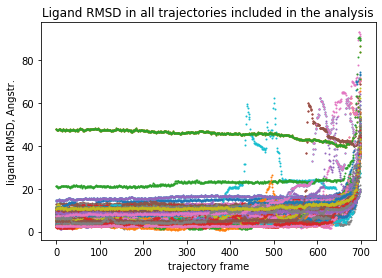

Traj to be discarded:  10 from  72
Original data size:  (50400, 1127)
Final data size:  (43400, 1127)
 trajectories now: 62


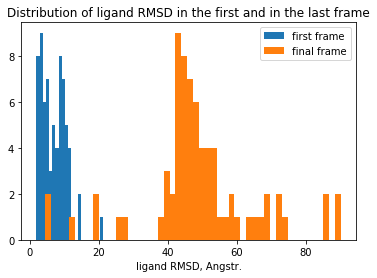

================ Summary=====================
rough estimation of tau =  12.512269765395308 0.5688066300666117 702.0 72
Egress into membrane (number of traj):  8 ( 11.1 %)


In [11]:
print(np.unique(df_tot_org.Traj.values.astype(int)).shape)
threshold_start_RMSD = 15
threshold_end_RMSD = 15
threshold_protein_RMSD = 10
lipid_interaction = 15

trj_to_discard = []
start_RMSD = []
end_RMSD = []
times = []
#tot_traj1 = 0
tot_traj = 0
k = 0

LIP_list = [r for r in df_tot_org.columns.values 
            if (r[:5] in ['RE_CH','RE_OL','RE_PA','RE_PE','RE_PC']) or  r.find('RE_PH-') >=0]
RE_list = [r for r in df_tot_org.columns.values 
            if ( not (r in LIP_list)  and r.find('RE_') >=0 )]
CHL_list = [r for r in df_tot_org.columns.values 
            if (r[:5] in ['RE_CH'])]

# loop over replicas
Lip_egress = 0
for j in np.unique(df_tot_org.Repl.values):
    df_tot_Repl = df_tot_org[df_tot_org.Repl == j]
    # loop over trajectories
    for i in np.unique(df_tot_Repl.Traj.values.astype(int)):
        tot_traj +=1
        df_tot_Repl_Traj = df_tot_Repl[df_tot_Repl.Traj == str(i)]
        start_RMSD.append(df_tot_Repl_Traj.RMSDl.values[0])
        end_RMSD.append(df_tot_Repl_Traj.RMSDl.values[-1])
        try:
            times.append(np.unique(df_tot_Repl_Traj.length.values)[0])
        except:
            print("ERROR---------------------------")
            print(np.unique(df_tot_Repl_Traj.length.values)[0])
        if(df_tot_Repl_Traj.RMSDl.values[0] > threshold_start_RMSD) :
            print("    too large ligand RMSD in the first frame : ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
        elif (df_tot_Repl_Traj.RMSDl.values[-1] < threshold_end_RMSD) :  
            trj_to_discard.append((j,i))
            print("    too small ligand RMSD at the end (to be discarded): ",df_tot_Repl_Traj.RMSDl.values[0],df_tot_Repl_Traj.RMSDl.values[-1])
            continue
        elif (df_tot_Repl_Traj.RMSDp.max() > threshold_protein_RMSD) :  
            trj_to_discard.append((j,i))
            print("    too large protein RMSD (to be discarded): ",df_tot_Repl_Traj.RMSDp.max())
            #continue
        elif "LIP" in  df_tot_Repl_Traj.columns.values:
            # select  frames where less than 2 non-scpecific ligand-protein contact found
            df_tot_diss = df_tot_Repl_Traj[df_tot_Repl_Traj[RE_list].sum(axis=1) < 1 ] 
            #  select frames  where lipids  contact with the ligand
            LIP_contacts = df_tot_diss[LIP_list].sum(axis=1).values 
            # only if ligand has contacts with more than 3 lipid in the first frame as ligand left the protein
            if len(LIP_contacts) > 0:
                if LIP_contacts[0] > 3 and len(LIP_contacts[LIP_contacts > 0]) > 1: 
                    print(k," LIPID interaction: ",j,i," Lip sum:",df_tot_diss.LIP.values[-20:].sum(),
                      "Wat sum: ",df_tot_diss.WAT.values[-20:].sum(),"Lip max contacts: ",np.max(LIP_contacts))
                    Lip_egress += 1
                    if noLIP: 
                        trj_to_discard.append((j,i))
                        k += 1
                        continue
        plt.plot(df_tot_Repl_Traj.RMSDl,marker='o', linestyle="",markersize=1)

plt.ylabel("ligand RMSD, Angstr.",fontsize=10)
plt.xlabel("trajectory frame",fontsize=10)
plt.title("Ligand RMSD in all trajectories included in the analysis")
plt.show()
print("Traj to be discarded: ", len(trj_to_discard), "from ",tot_traj)
print("Original data size: ",df_tot_org.shape)
for j,i in trj_to_discard:
#    print("To discard:",i,j)
    df_tot_org = df_tot_org[~((df_tot_org.Traj == str(i)) & (df_tot_org.Repl == j))]
print("Final data size: ",df_tot_org.shape)
print(" trajectories now:",df_tot_org[df_tot_org.time == 0].shape[0])

plt.hist(start_RMSD,bins=50, label= "first frame")
plt.hist(end_RMSD,bins=50, label= "final frame")
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.legend(fontsize = 10)
plt.title("Distribution of ligand RMSD in the first and in the last frame")
plt.show()

bt2 = bootstrapp(times, rounds=50000)
mu, std = norm.fit(bt2)
print("================ Summary=====================")
print("rough estimation of tau = ",mu,std,max(times),len(times))
print("Egress into membrane (number of traj): ",  Lip_egress,"(",np.round(100*Lip_egress/tot_traj,1),"%)")


In [12]:
df_tot_org[LIP_list].loc[(df_tot_org[LIP_list]!=0).any(1)].shape

(8769, 479)

## 1.4 Map all trajectories on a 3D grid 

In [13]:
#IFP_data
DIR_out+"density-all-FV-"+version+".dx"

df_tot_to_save = df_tot_org # all snapshots
if noLIP:
    Map_3D_grid(df_tot_to_save,DIR_out+"density-noLIP-FV-"+version+".dx") 
else:
    Map_3D_grid(df_tot_to_save,DIR_out+"density-all-FV-"+version+".dx")


## 1.5  Plot RMSD and ligand COM for the last N frames in dissociation trajectories
    N- namber of frames in the IFP database (*pkl files)

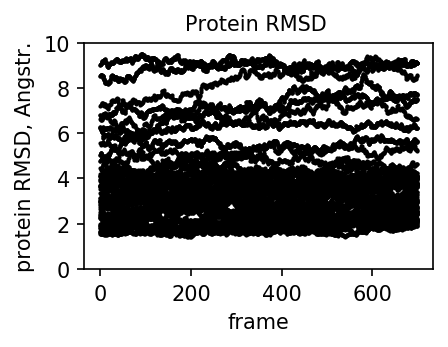

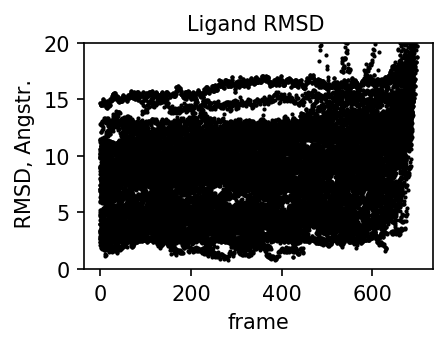

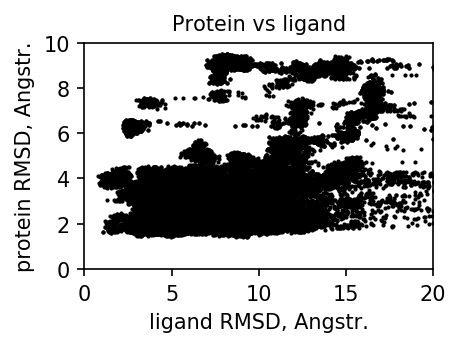

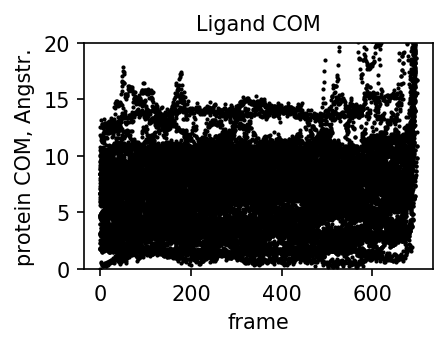

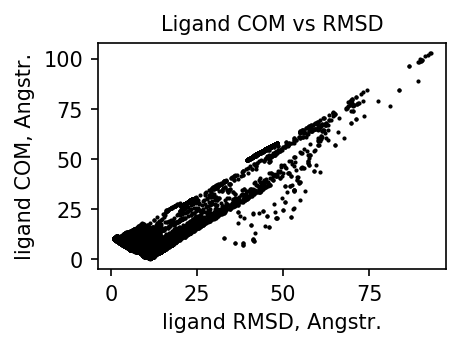

In [14]:
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,df_tot_org.RMSDp, s=1, color = "k")
plt.xlabel("frame",fontsize=10)
plt.ylabel("protein RMSD, Angstr.",fontsize=10)
plt.title("Protein RMSD ",fontsize=10)
plt.ylim(0,10)
plt.show()

fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,df_tot_org.RMSDl, s=1, color = "k")
plt.xlabel("frame",fontsize=10)
plt.ylabel(" RMSD, Angstr.",fontsize=10)
plt.title("Ligand RMSD ",fontsize=10)
plt.ylim(0,20)
plt.show()
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.RMSDl,df_tot_org.RMSDp, s=1, color = "k")
plt.ylabel("protein RMSD, Angstr.",fontsize=10)
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.title("Protein vs ligand",fontsize=10)
plt.xlim(0,20)
plt.ylim(0,10)
plt.show()

dist = np.sqrt((df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])*(df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])+(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])*(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])+(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0])*(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0]))
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.time,dist, s=1, color = "k")
plt.ylabel("protein COM, Angstr.",fontsize=10)
plt.xlabel("frame",fontsize=10)
plt.title("Ligand COM",fontsize=10)
plt.ylim(0,20)
plt.show()

dist = np.sqrt((df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])*(df_tot_org.COM_x.values-df_tot_org.COM_x.values[0])+(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])*(df_tot_org.COM_y.values-df_tot_org.COM_y.values[0])+(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0])*(df_tot_org.COM_z.values-df_tot_org.COM_z.values[0]))
fig = plt.figure(figsize = (3, 2),facecolor='w',dpi=150)
plt.scatter(df_tot_org.RMSDl,dist, s=1, color = "k")
plt.xlabel("ligand RMSD, Angstr.",fontsize=10)
plt.ylabel("ligand COM, Angstr.",fontsize=10)
plt.title("Ligand COM vs RMSD",fontsize=10)
plt.show()

# 2. Finding dissociation pathways and metastable states using kmean clustering

##   2.1 Change residue numbering and extract a list of columns that correspond IFP only or any contacts(RE) 

In [15]:
# --- Select IFP only-
ifp_all_list = IFP_all

ifp_list = IFP_RE  # will do clustering on unspecific contacts 

# we will re-number residues to X-ray numbering a for convinience and select only contacts from the ifp_list
shift = 0
columns_IFP = []
columns_IFP_all = []
columns_IFP_renamed = {}
for c in df_tot_org.columns.values:
    if c in LIP_list: continue  # we will not use ligand-lipid contacts for clustering
    if c[0:2] in IFP_mixed :   
        if M2:
            if int(c[6:]) < 215: shift = 18
            else:     shift= 164 
        elif AR:
            if int(c[6:]) < 200: shift = 31
            elif int(c[6:]) < 360: shift = 800
            else: shift = -97
        if c[0:2] in ifp_list: 
            columns_IFP.append(c[:6]+str(int(c[6:])+shift))
        if c[0:2] in ifp_all_list: 
            columns_IFP_all.append(c[:6]+str(int(c[6:])+shift))
        columns_IFP_renamed.update( {c : c[:6]+str(int(c[6:])+shift)} )
df_tot = df_tot_org.rename(columns_IFP_renamed, axis='columns')


## 2.2 Re-organize the  IFP dataframe df_ext and prepare IFP matrix X for clustering:
    Split COM to com_x, com_y, com_z; 
    make matrix X for clustering;
    Change a dataset for clastering from pure IFP (and or RE contacts) to the mixed one by adding a column with the number of  observed contacts


In [16]:
unpickled_df=df_tot        

# remove rare contacts
df_ext_tmp = unpickled_df[columns_IFP]        
print("Original ", df_ext_tmp.shape)
columns_IFP_reduced = np.asarray(columns_IFP)[df_ext_tmp.sum(axis=0).values > 0]
df_ext = df_ext_tmp[columns_IFP_reduced]   
columns_IFP = columns_IFP_reduced
print("Reduced", df_ext_tmp.shape)
        
X = df_ext_tmp.values
    
print(X.shape)
if "Auxi_2" in unpickled_df.columns: # column Auxi-2 containes RMSD of the PAM
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM","Auxi_2" ]
elif "WAT" in unpickled_df.columns: # add water analysis if it is included in the DataFrame
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","WAT","RGyr","COM_x","COM_y","COM_z","COM"]
else:
    add_columns = ["Repl","ligand","Traj","RMSDl","time","length","RGyr","COM_x","COM_y","COM_z","COM"]
df_ext[add_columns] = unpickled_df[add_columns]

#count = df_tot_org[columns_IFP_renamed].sum(axis=1).values
#count = count.reshape(count.shape[0],1)
# Xt(i,j) is a numpy matrix containing IFPs (j) for all frammes (i) that well be used fro clustering
Xt = X #np.concatenate((X,10*count/np.amax(count)),axis =1)

Original  (43400, 206)
Reduced (43400, 206)
(43400, 206)


## 2.3. Selection of  the cluster number (not really usefull)
### 2.3.1 Silhouette_score

In [17]:
# set True to run cluster evaluation
Evaluate_cluster_k = False
if Evaluate_cluster_k:
    from sklearn.metrics import silhouette_score
    Sum_of_squared_distances = []
    sil = []
    K = range(3,17)
    for k in K:
        km = KMeans(n_clusters=k, random_state=0, algorithm ="full").fit(Xt)
        Sum_of_squared_distances.append(km.inertia_)
        sil.append(silhouette_score(Xt, km.labels_, metric = 'euclidean'))                
    
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    plt.plot(K, sil, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()


### 2.3.2 Gap Statistic
    result depends strongly on the system; 
    therefore, this is not really usefull - just as an additional check)

In [18]:


def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from
    Tibshirani R, Walther G and Hastie T, 
    Estimating the number of clusters in a data set via the gap statistic, 
    J. R. Statist. Soc. B (2001) 63, Part 2, pp. 411–423
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        print(k)
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    
# set True to run cluster evaluation
Evaluate_cluster_k_withGap = False

if Evaluate_cluster_k_withGap:
    k, gapdf = optimalK(Xt, nrefs=5, maxClusters=15)
    plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
    plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count')
    plt.ylabel('Gap Value')
    plt.title('Gap Values by Cluster Count')
    plt.show()

## 2.3  Clustering

In [19]:
# different clustering procedures can be used
#from kmodes.kmodes import KModes
kmodes = False #to use kmode, one has to instal KModes package and uncomment line above

GM  = False
Optics = False
Frame_clusters = 10

if GM: 
    from sklearn import mixture
    gmm = mixture.GaussianMixture(n_components=Frame_clusters, covariance_type='full').fit(Xt)
    labels_ = gmm.predict(Xt)
elif kmodes:
    km = KModes(n_clusters=Frame_clusters, init='Huang', n_init=2, verbose=1).fit_predict(Xt) 
    labels_ = km.labels_
elif Optics:
    from sklearn.cluster import OPTICS
    km = OPTICS(min_samples=2).fit(Xt)
    labels_ = km.labels_
else:
    km = KMeans(n_clusters=Frame_clusters, algorithm ="full" , random_state=0).fit(Xt)
    labels_list = np.unique(km.labels_)
    labels_ = km.labels_

labels_rename = labels_

# we will rename labels to make another  position of the cluster plot (to put clasters more distantly) 
# is is needed to exactly reproduce plots from the paper, othervise, it is not nessesary
if AR:
    #
    labels_rename = []
    for l in labels_:
        if l == 4: labels_rename.append(7)
        elif l == 7:  labels_rename.append(4)
        else: labels_rename.append(l)
elif M2 and ( version == "f12_")  :
    labels_rename = []
    for l in labels_:
        if ligand == "IXO-CHL" :
            if l == 2: labels_rename.append(8)
            elif l == 8:  labels_rename.append(2)
            else: labels_rename.append(l)
        else:
            labels_rename = labels_
else: labels_rename = labels_
    
    
# we add cluster labels to the data frame
df_ext["label"] = labels_rename

print(df_ext.shape,Xt.shape)



(43400, 197) (43400, 206)


## 2.4 Find and visualize metastable states from clustering (using undefined contacts RE*)

cluster  0 STD of COM:  1.1993478158941415 1.4823559391949535 1.2756141620097485 STD of RMSD:  1.5159475820490516 Water: []
cluster  1 STD of COM:  1.1360460974706281 1.5311314439690287 3.1730471597558676 STD of RMSD:  2.415161305530312 Water: []
cluster  2 STD of COM:  1.228072072586732 1.2094285375400287 1.2910140024634529 STD of RMSD:  1.2834936925419662 Water: []
cluster  3 STD of COM:  1.5954954027224284 2.62789579427357 2.4029664807842823 STD of RMSD:  2.654107689445828 Water: []
cluster  4 STD of COM:  0.7355434615831388 1.6660262459607524 0.9371847388427909 STD of RMSD:  1.770743184379563 Water: []
cluster  5 STD of COM:  0.9326239482193889 1.4449203114166644 1.865188069582178 STD of RMSD:  2.0190136100190608 Water: []
cluster  6 STD of COM:  1.2692555941437607 1.4397864884116698 2.072684376115926 STD of RMSD:  1.7309086443750201 Water: []
cluster  7 STD of COM:  2.037946654396212 1.942954280525241 1.9933220333951964 STD of RMSD:  1.8462892588404898 Water: []
cluster  8 STD of 

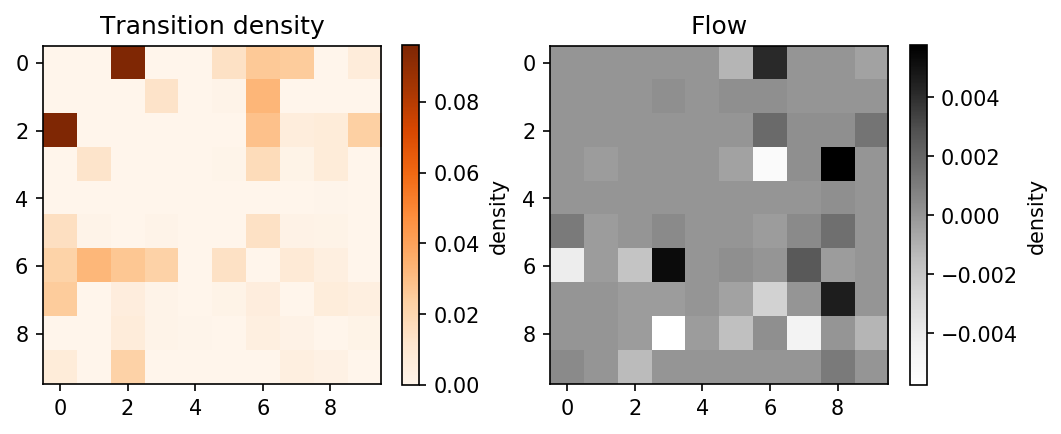

Flow:
 [[  0   0   0   0   0 -11  41   0   0  -4]
 [  0   0   0   2   0   2   2   0   0   0]
 [  0   0   0   0   0   0  18   2   2  13]
 [  0  -2   0   0   0  -4 -52   2  57   0]
 [  0   0   0   0   0   0   0   0   2   0]
 [ 11  -2   0   4   0   0  -2   4  16   0]
 [-41  -2 -18  52   0   2   0  25  -2   0]
 [  0   0  -2  -2   0  -4 -25   0  46   0]
 [  0   0  -2 -57  -2 -16   2 -46   0 -11]
 [  4   0 -13   0   0   0   0   0  11   0]]
COLORS (i.e. averade RMSD) to be used in each cluster for plotting:  [10. 30.  0. 30. 50. 20. 20. 20. 62. 10.]


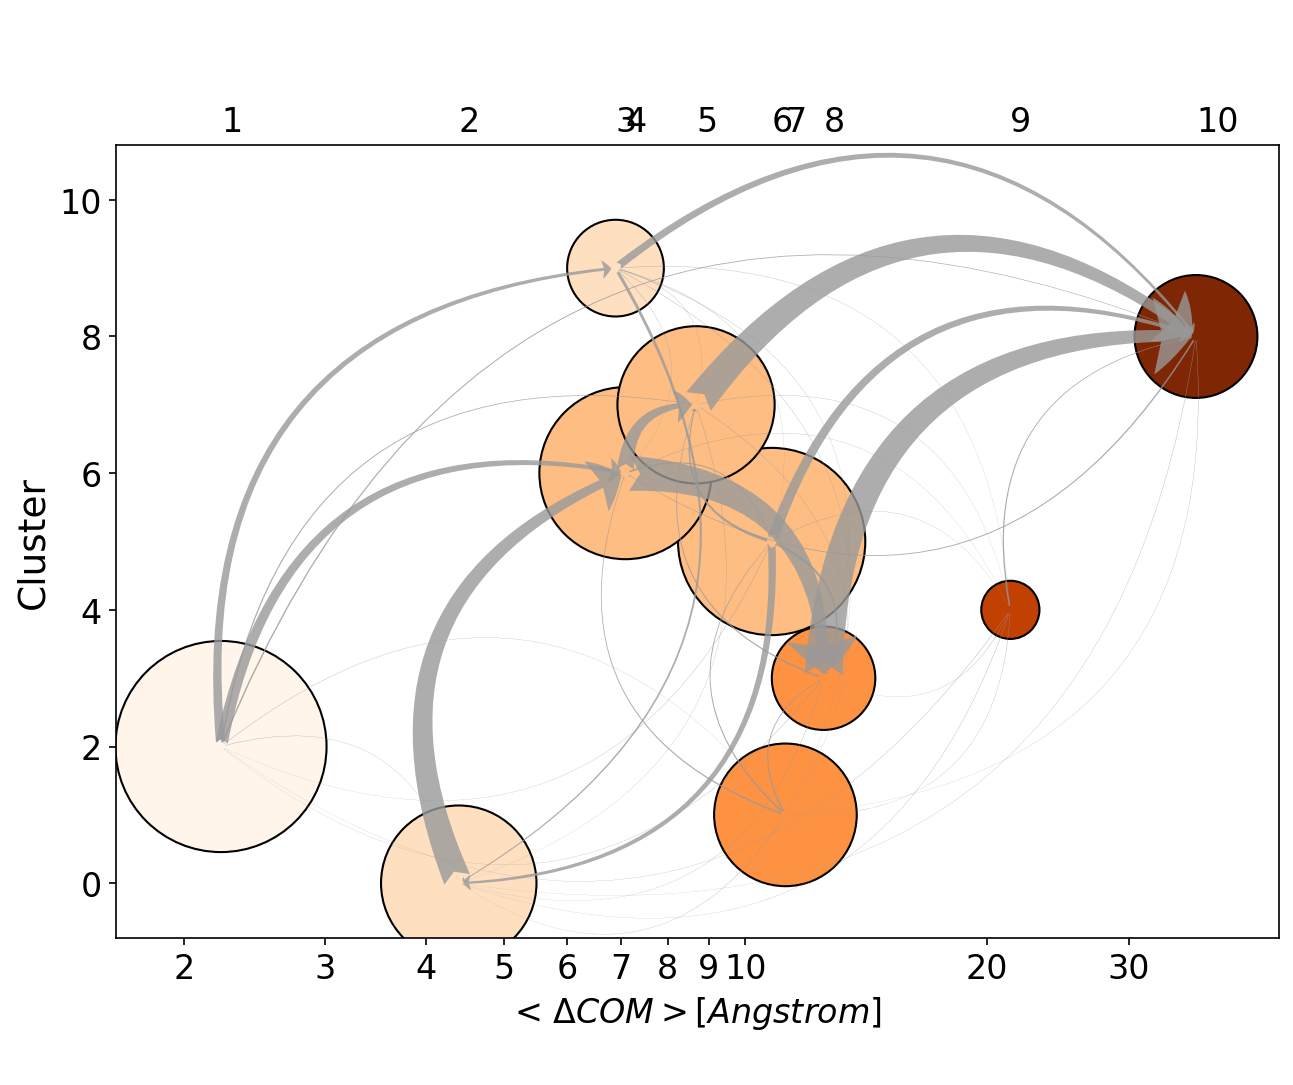

In [20]:
out_name = "cluster-traj.png"
arg_Label_list = plot_graph_COM_v1(df_ext,DIR_out+out_name,ligand=[],draw_round = False,water=False,edges_show=False,diss_show=False)


## 2.5 Cluster components
### 2.5.1 Show cluster  composition as obtained from clustering (based on RE)

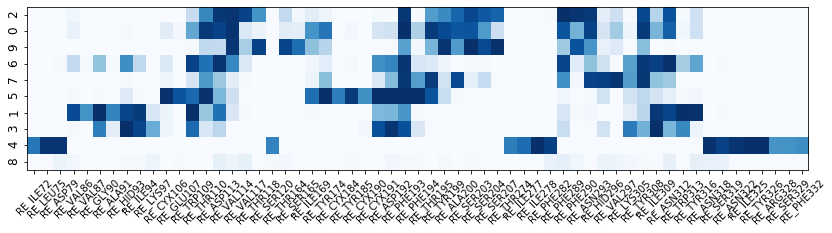

In [21]:
threshold = 0.5

sorted_labels = labels_list[arg_Label_list]

file_save = DIR_out+"cluster_traj-population-img.png"
df_ext_ligand = df_ext[df_ext.ligand.isin([ligand])]

p = []
for c in columns_IFP: p.append(c[6:])
indx = np.argsort(np.asarray(p).astype(float))  

ar = np.zeros((len(sorted_labels),indx.shape[0]), dtype = float)
for i,l in enumerate(sorted_labels):
    ar[i] = df_ext[df_ext.label == l][columns_IFP].mean().values[indx]
    
br = np.max(ar,axis=0)
indx_threshold = np.where(br > threshold)[0]
col_threshold = np.asarray(columns_IFP)[indx][indx_threshold]

RE_col_threshold = []
IFP_col_threshold = []
RE_indx_threshold = []
IFP_indx_threshold = []

for i,c in enumerate(col_threshold):
    if c[:2] == "RE": 
        RE_col_threshold.append(c[3:])
        RE_indx_threshold.append(i)
    else: 
        IFP_col_threshold.append(c)
        IFP_indx_threshold.append(i)
IFP_indx_threshold = np.asarray(IFP_indx_threshold)
IFP_col_threshold = np.asarray(IFP_col_threshold)
RE_col_threshold = np.asarray(RE_col_threshold)
RE_indx_threshol = np.asarray(RE_indx_threshold)


fig = plt.figure(figsize = (14, int(Frame_clusters/3.1)),facecolor='w')
ax = plt.subplot(1,1,1)
plt.imshow(ar[:,indx_threshold],cmap='Blues',aspect = "auto")
plt.xticks(range(0,col_threshold.shape[0]),col_threshold ,rotation=45,fontsize=10)
plt.yticks(range(0,len(sorted_labels)),sorted_labels,rotation=90,fontsize=12)
#plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=12)
if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
else: plt.show()


### 2.5.2 Show IFP contribution to each cluster 

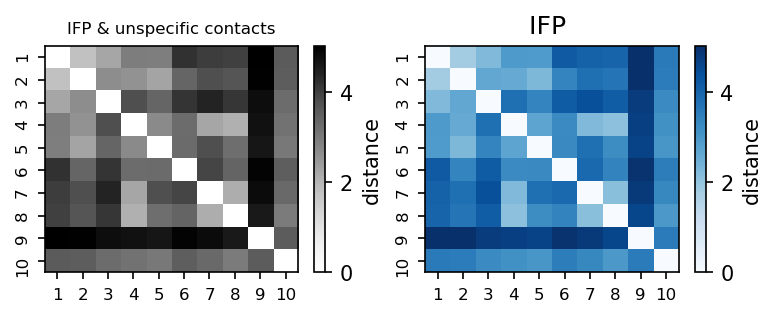

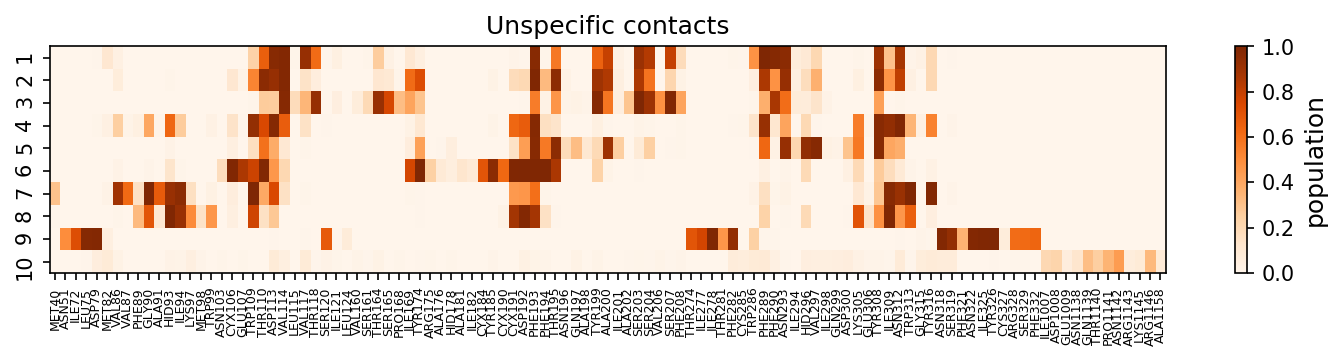

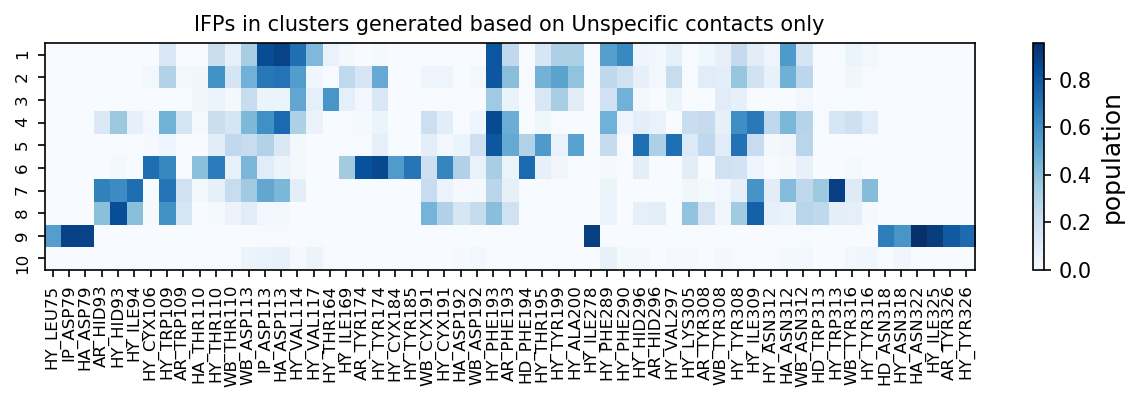

In [22]:
# threshold used to discurd some IFPs (less populated) from the image plot 
threshold = 0.05

sorted_labels = labels_list[arg_Label_list]

file_save = DIR_out+"cluster_traj-population-img.png"
df_ext_ligand = df_ext[df_ext.ligand.isin([ligand])]

p = []
for c in columns_IFP: p.append(c[6:])
indx = np.argsort(np.asarray(p).astype(float))  

p_ifp = []
for c in columns_IFP_all: p_ifp.append(c[6:])
indx_ifp = np.argsort(np.asarray(p_ifp).astype(float))  

ar = np.zeros((len(sorted_labels),indx.shape[0]), dtype = float)
ar_ifp = np.zeros((len(sorted_labels),indx_ifp.shape[0]), dtype = float)
for i,l in enumerate(sorted_labels):
    ar[i] = df_ext[df_ext.label == l][columns_IFP].mean().values[indx]
    ar_ifp[i] = unpickled_df[df_ext.label == l][columns_IFP_all].mean().values[indx_ifp]
    
br = np.max(ar,axis=0)
indx_threshold = np.where(br > threshold)[0]
col_threshold = np.asarray(columns_IFP)[indx][indx_threshold]

RE_col_threshold = []
IFP_col_threshold = []
RE_indx_threshold = []
IFP_indx_threshold = []

for i,c in enumerate(col_threshold):
    if c[:2] == "RE": 
        RE_col_threshold.append(c[3:])
        RE_indx_threshold.append(i)
    else: 
        IFP_col_threshold.append(c)
        IFP_indx_threshold.append(i)
IFP_indx_threshold = np.asarray(IFP_indx_threshold)
IFP_col_threshold = np.asarray(IFP_col_threshold)
RE_col_threshold = np.asarray(RE_col_threshold)
RE_indx_threshol = np.asarray(RE_indx_threshold)

#--- compute and show 2D distance matrics of IFPs
e_dist = np.zeros((ar.shape[0],ar.shape[0]))
e_dist_ifp = np.zeros((ar.shape[0],ar.shape[0]))
for i,ar1 in enumerate(ar):
    for j,ar2 in enumerate(ar):
        e_dist[i,j] = numpy.linalg.norm(ar1-ar2)
        e_dist_ifp[i,j] = numpy.linalg.norm(ar1[indx]-ar2[indx])
    

fig = plt.figure(figsize = (6, 2),facecolor='w',dpi=150)
ax = plt.subplot(1,2,1)
ec=plt.imshow(e_dist,cmap='Greys',aspect = "auto")
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=8)
plt.xticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=8)
cbar = plt.colorbar(ec)
cbar.set_label('distance')
ax.set_title("IFP & unspecific contacts",fontsize=8)
ax = plt.subplot(1,2,2)
ec=plt.imshow(e_dist,cmap='Blues',aspect = "auto")
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=8)
plt.xticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=8)
ax.set_title("IFP ")
cbar = plt.colorbar(ec)
cbar.set_label('distance')
plt.show()


# show IFP composition of the generated clusters
if len(ifp_list) > 1:
    file_save = DIR_out+"cluster_traj-population-IFP-img.png"
    fig = plt.figure(figsize = (12, int(Frame_clusters/4.1)),facecolor='w',dpi=150)
    ax = plt.subplot(1,1,1)
    max_ar = np.amax(ar[:,indx_threshold][:,IFP_indx_threshold])
    ec=plt.imshow(ar[:,indx_threshold][:,IFP_indx_threshold],cmap='Blues',aspect = "auto")
    plt.xticks(range(0,col_threshold[IFP_indx_threshold].shape[0]),col_threshold[IFP_indx_threshold] ,rotation=90,fontsize=6)
    plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),fontsize=8,rotation=90)
    ax.set_title("IFP ")
    cbar = plt.colorbar(ec)
    cbar.set_label('population',fontsize=12)

    if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
    else: plt.show()

# show unspecific contact contribution is they are included in clustering
if "RE" in ifp_list: 
    fig_l = 10
    if M2 : fig_l = 8
    file_save = DIR_out+"cluster_traj-population-RE-img.png"
    fig = plt.figure(figsize = (12, int(Frame_clusters/5.)),facecolor='w',dpi=150)
    ax = plt.subplot(1,1,1)
    ec=plt.imshow(ar[:,indx_threshold][:,RE_indx_threshold],cmap='Oranges',aspect = "auto")
    plt.xticks(range(0,col_threshold[RE_indx_threshold].shape[0]),RE_col_threshold ,rotation=90,fontsize=6)
    plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=10)
    ax.set_title("Unspecific contacts",fontsize=12)
    cbar = plt.colorbar(ec)
    cbar.set_label('population',fontsize=12)
    
    if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
    else: plt.show()
    if len(ifp_list) == 1:
        threshold_ifp = 0.5
        file_save = DIR_out+"cluster_traj-population-IFP-img.png"
        fig = plt.figure(figsize = (fig_l, int(Frame_clusters/5.)),facecolor='w',dpi=150)
        ax = plt.subplot(1,1,1)
        ec=plt.imshow(ar_ifp[:,np.sum(ar_ifp,axis=0)> threshold_ifp],cmap='Blues',aspect = "auto")
        ax.set_title("IFPs in clusters generated based on Unspecific contacts only",fontsize=10)
        plt.xticks(range(0,np.array(columns_IFP_all)[np.sum(ar_ifp,axis=0)> threshold_ifp].shape[0]),np.array(columns_IFP_all)[indx_ifp][np.sum(ar_ifp,axis=0)> threshold_ifp],rotation=90,fontsize=8)
        plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=90,fontsize=8)
        cbar = plt.colorbar(ec)
        cbar.set_label('population',fontsize=12)
        if file_save !="":plt.savefig(file_save,format='png', dpi=300, bbox_inches='tight',transparent=True)  
        else: plt.show()
    


## 2.6  Save clasters on a 3D grid; use COM of just one ligand

In [23]:
for k in np.unique(df_ext.label.values):
    df_cl = df_ext
    d_cluster = df_cl[df_cl.label == k]
    if d_cluster.shape[0] > 10:
        Map_3D_grid(d_cluster,DIR_out+"cluster-"+str(Frame_clusters)+"RE-FV-"+version+str(k)+".dx")
        


##  2.7 Identification of the snapshot from IFP database
     this block of scripts helps to reconstract  a complete pathes to trajectories where IFP were computed
     For this input files *dat are used

In [24]:
def get_traj_name(d,name_template,name_len = 8):
    unpickled_dfi = []
    directi = []
    j = 0
    for i,lig_pkl in enumerate(glob.glob(d+name_template)):
        name= lig_pkl[len(d):len(d)+name_len]
        print(lig_pkl,name)
        trj_length = []
        if os.path.exists(lig_pkl[:-3]+"dat"):
            print("Trajectory length will be taken from "+lig_pkl[:-3]+"dat")
            with open(lig_pkl[:-3]+"dat", 'r', encoding='utf-8') as infile:
                for line in infile:
                    if line.find("Complete TRJ") >= 0:  
                        trj_length.append(int(line[line.find("xtc")+4:])/500.0)
                        directi.append(line[line.find("/"):line.find("xtc")+4])
                        print(line[line.find("/"):line.find("xtc")+4])
        df_lig= pd.read_pickle(lig_pkl)
        j += len(np.unique(df_lig.Traj.values))
        print(i, "---",j,np.unique(df_lig.Traj.values))
        #--- INCLUDE INFORMATION ABOUT TRAJECTORY LENGTH FROM A SEPARATE FILE IF IT EXISTS
        if len(trj_length) > 0:
            start = np.argwhere(df_lig.time.values == 0).flatten()
            if len(start) == len(trj_length):
                R = -1
                tR = []
                for i in range(0,df_lig.shape[0]): 
                    if i in start: R += 1
                    tR.append(trj_length[R])
                df_lig['length'] = tR
            else:
                print("Number of trajectories in pkl and dat files are different! - ",lig_pkl)
#        unpickled_dfi.append(df_lig)
PRINT_PATH = False
if PRINT_PATH:
    get_traj_name(DIR_in,name_template)

# 3. Motion of the allosterinc ligand (PAM) in simulations of iperoxo dissiociation 

In [25]:
if ligand ==  "IXO-ALO":
    top = cm.get_cmap('Oranges_r', 12)
    bottom = cm.get_cmap('Blues', 12)
    color = np.vstack((top(np.linspace(0, 1, 12)), bottom(np.linspace(0, 1, 12))))

    if "Auxi_2" in df_ext.columns.values:
        fig = plt.figure(figsize=(4, 3),dpi=150)
        gs = gridspec.GridSpec(2, 1,hspace = 0.4) # width_ratios=[4, 2, 1]) 
        df_2CU = df_ext[df_ext.Auxi_2 > 4]
        i = 0
        for r in np.unique(df_2CU.Repl.values):
            tt = df_ext[df_ext.Repl == r]
            for t in np.unique(tt.Traj.values):
               # print(r,t,np.unique(tt[tt.Traj == t].label.values))
                c = color[i]
                i += 3
                ax = plt.subplot(gs[0])
                plt.plot(tt[tt.Traj == t].time.values,tt[tt.Traj == t].Auxi_2.values,label=(r,t), lw=2,color = c)
                plt.xlim(600,700)
                plt.ylim(0,10)
                plt.ylabel('PAM RMSD ',fontsize=10)
                ax = plt.subplot(gs[1])
                plt.plot(tt[tt.Traj == t].time.values,tt[tt.Traj == t].RMSDl.values,label=(r,t), lw=2,color = c)
                plt.xlim(600,700)
                plt.ylim(0,50)
                plt.ylabel('Iperoxo RMSD ',fontsize=10)
        plt.xlabel('frame',fontsize=10)
        plt.show()


#  4.  Exploring ligand solvation (data are available only for  β2AR - β2-adrenergic receptor )
    orange and blue lines - the number of ligand and water atoms, respectively,  in the binding pocket

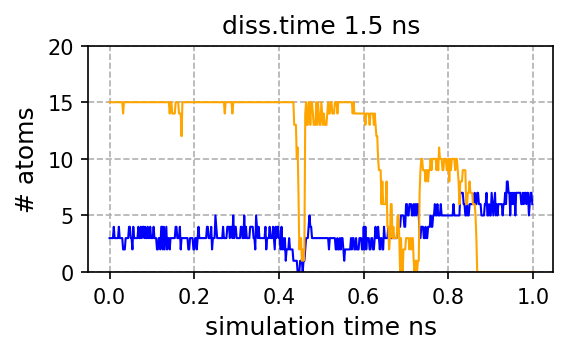

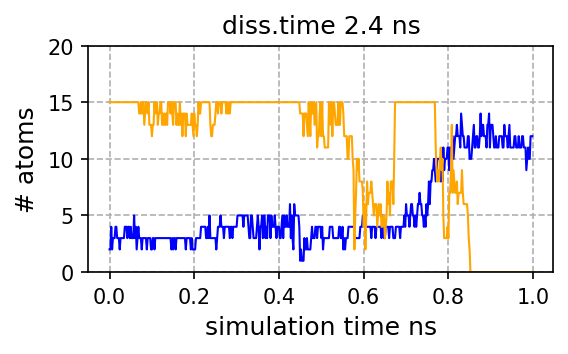

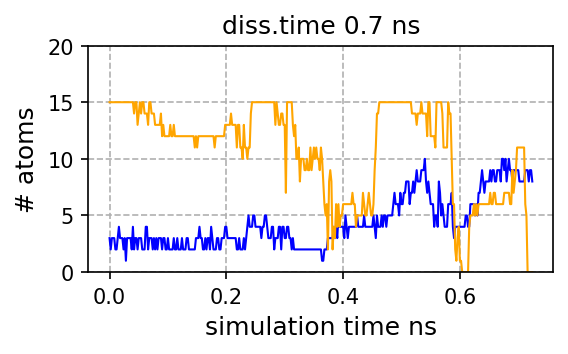

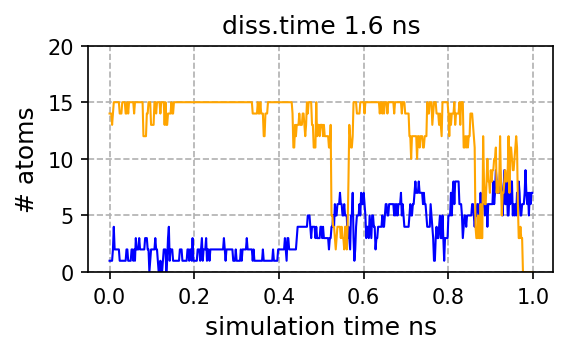

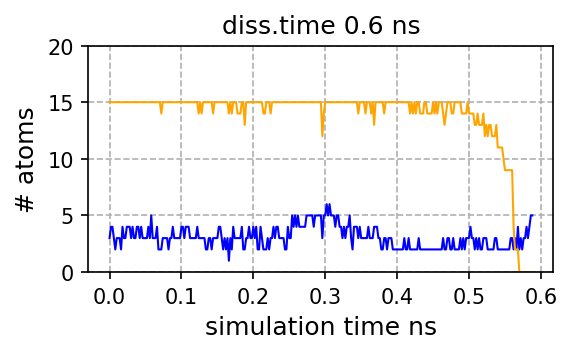

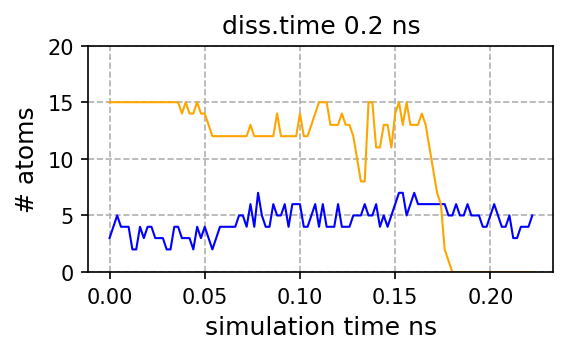

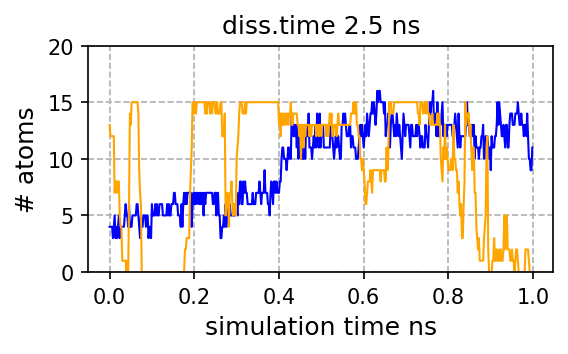

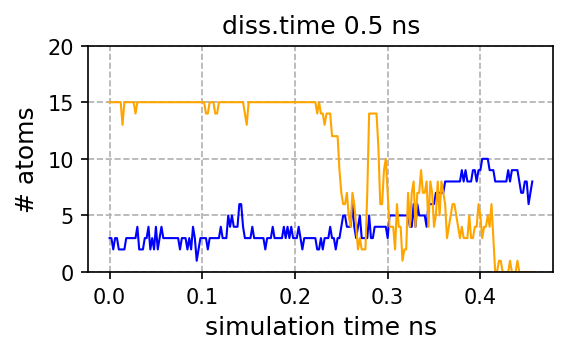

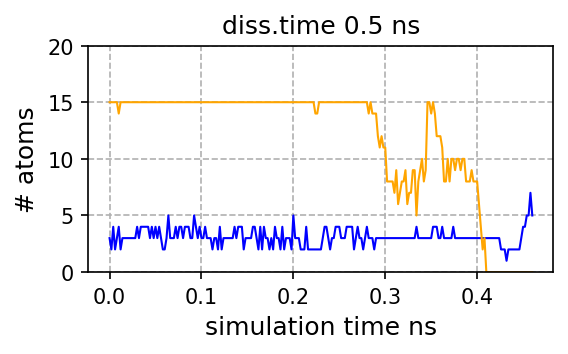

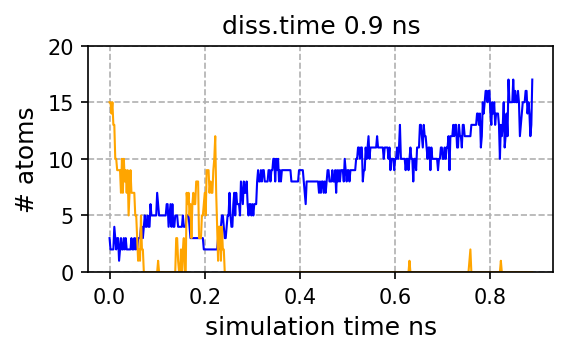

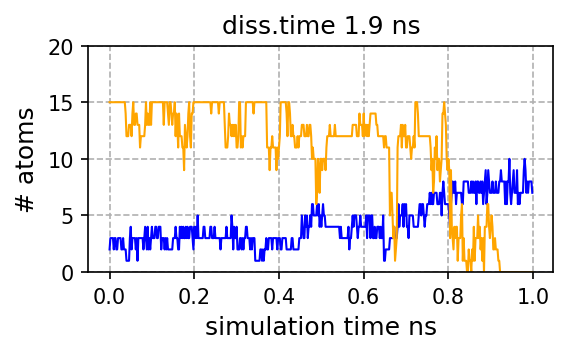

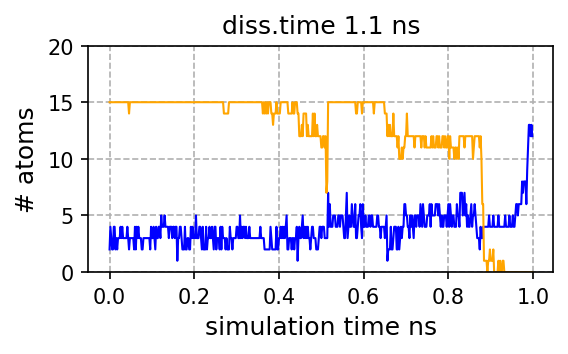

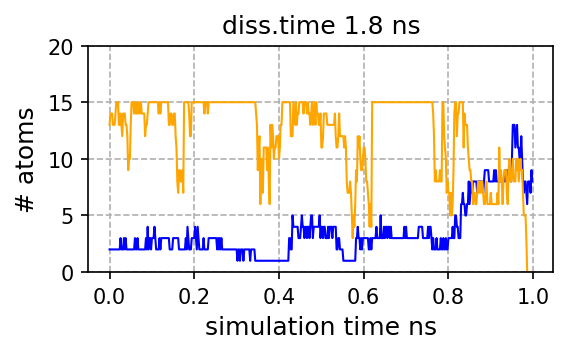

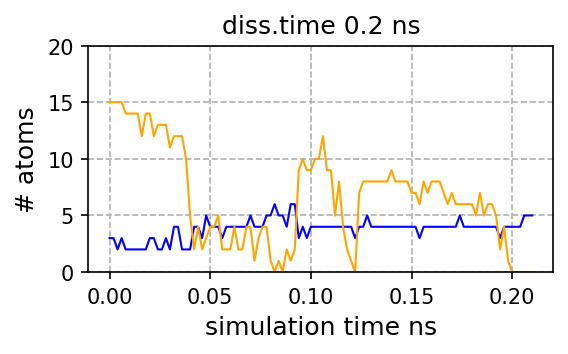

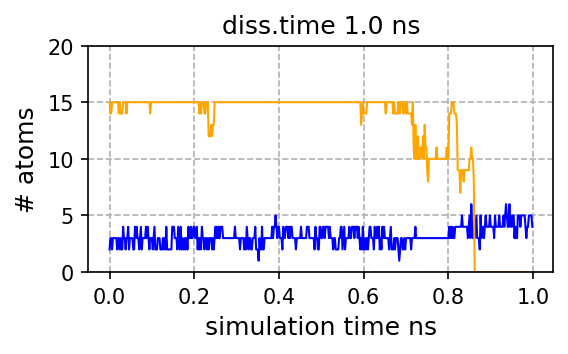

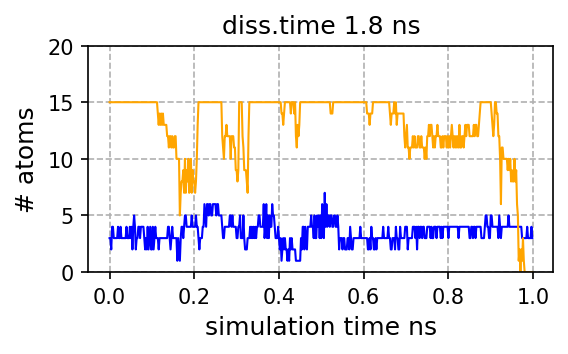

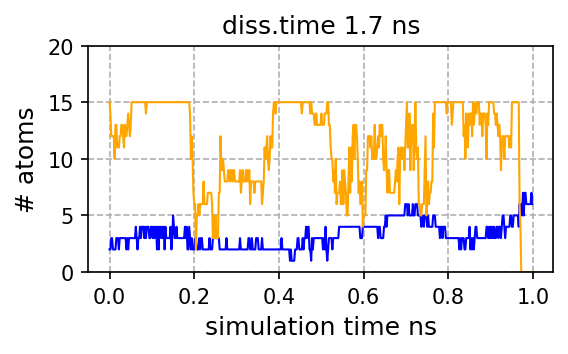

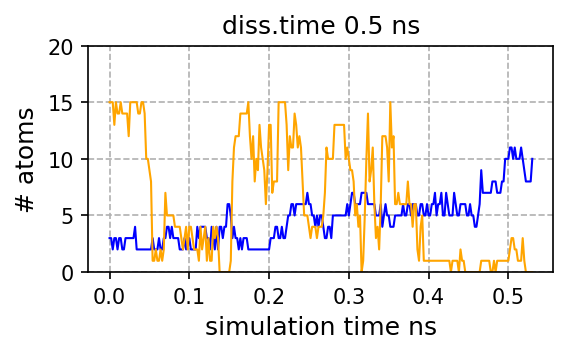

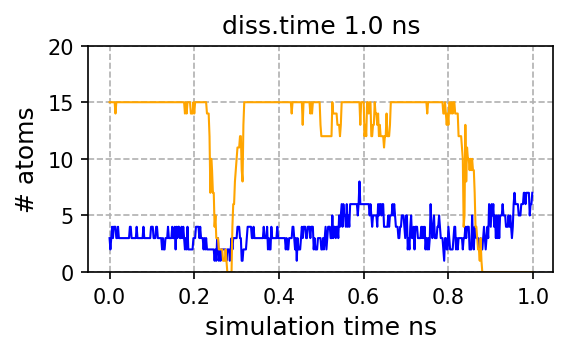

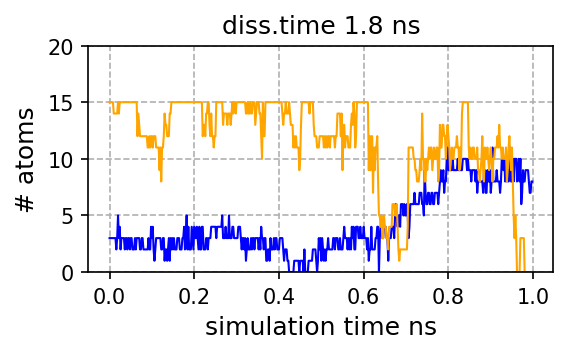

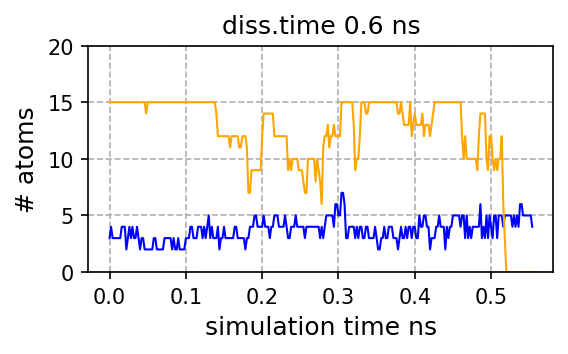

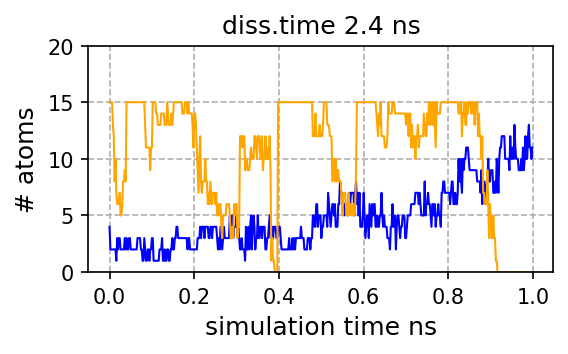

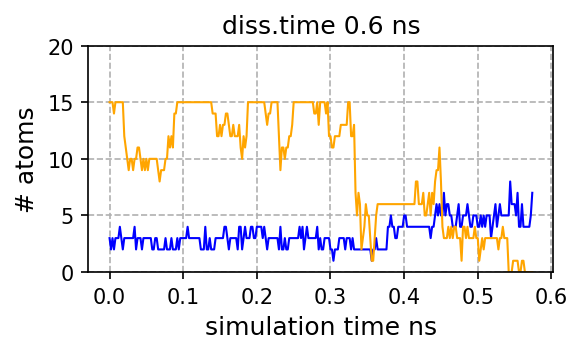

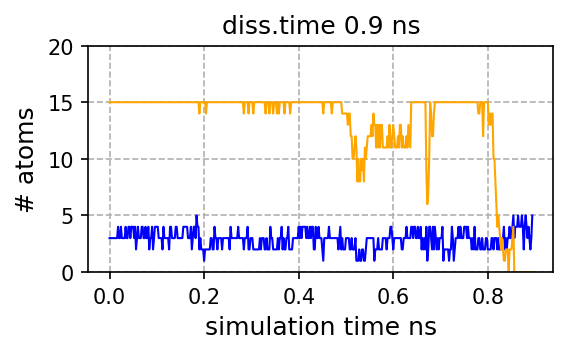

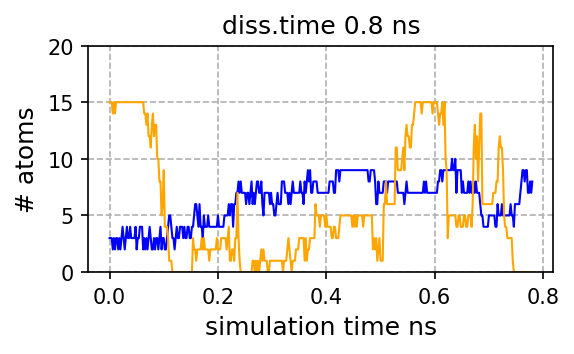

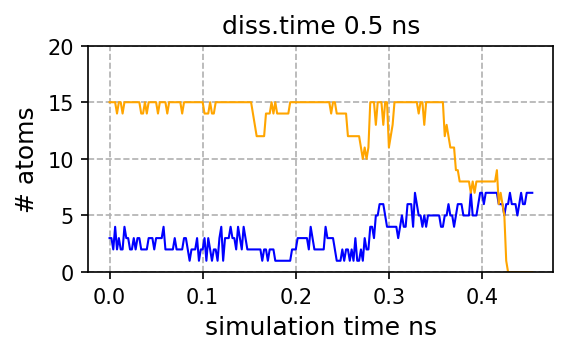

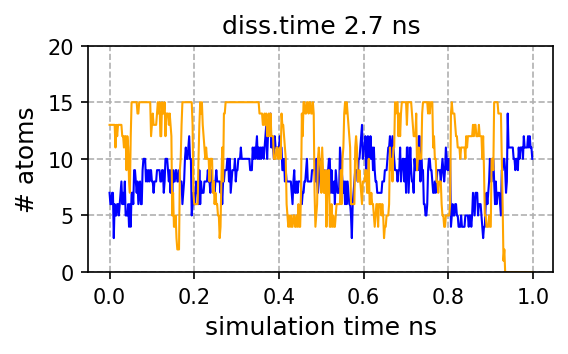

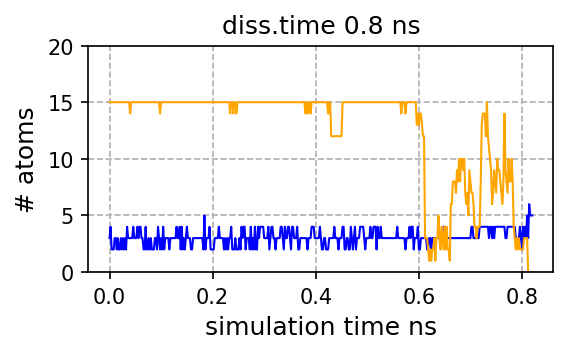

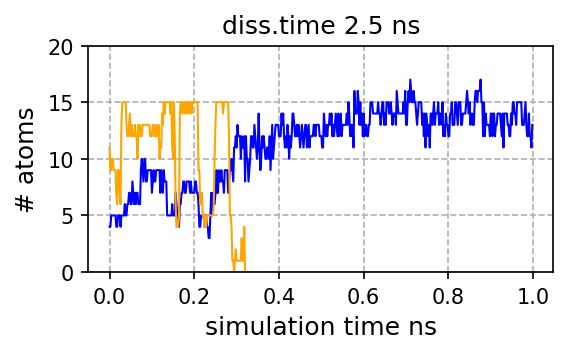

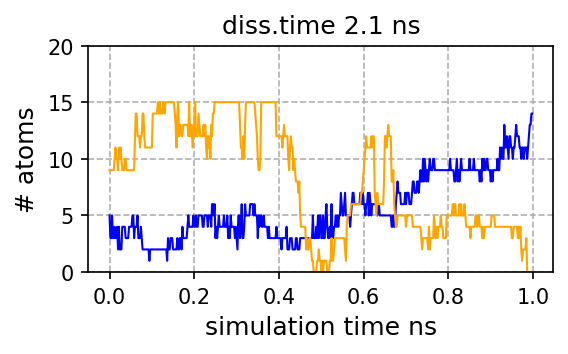

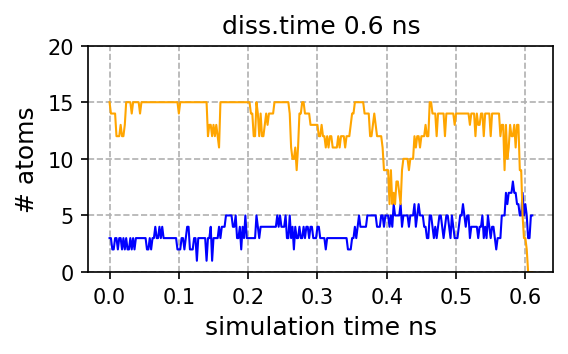

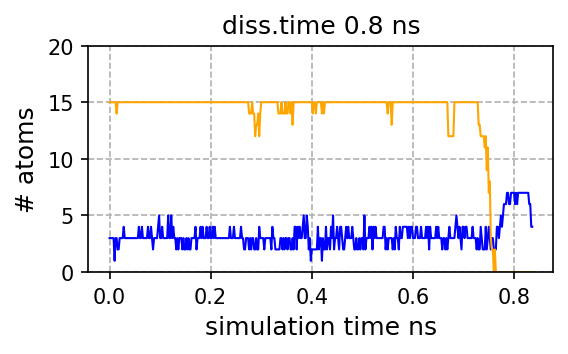

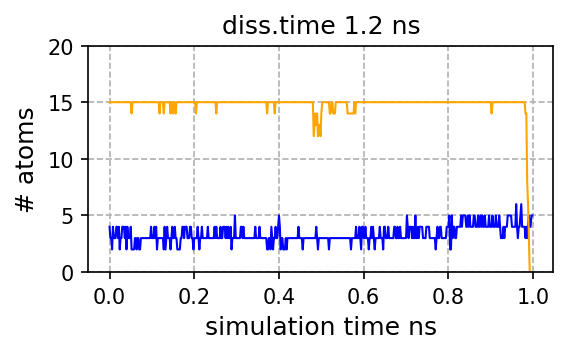

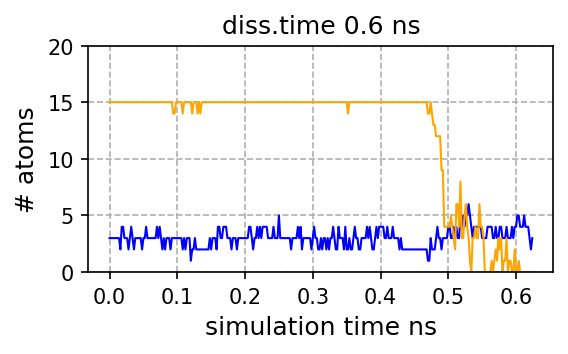

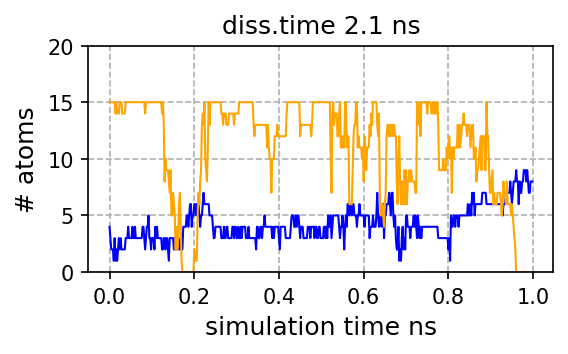

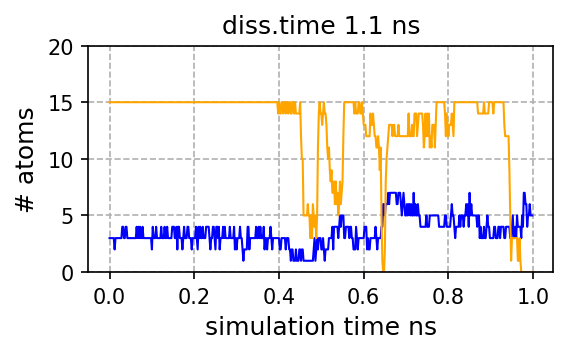

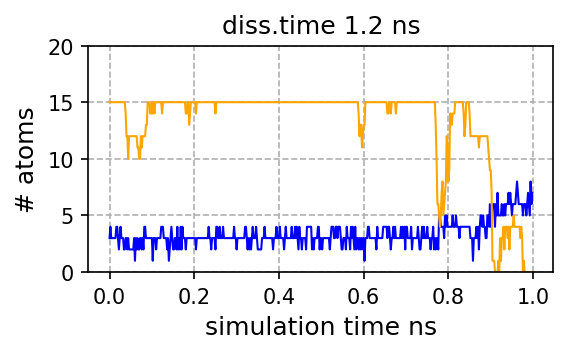

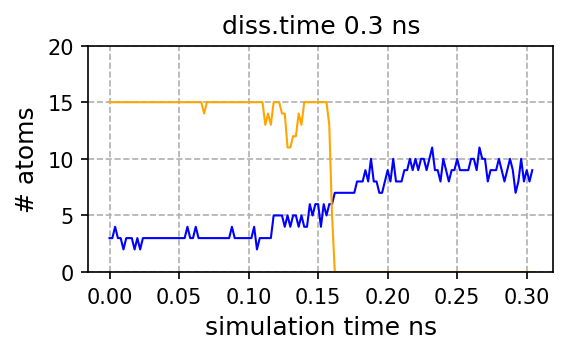

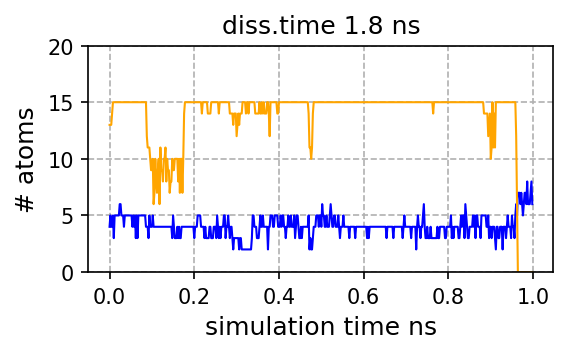

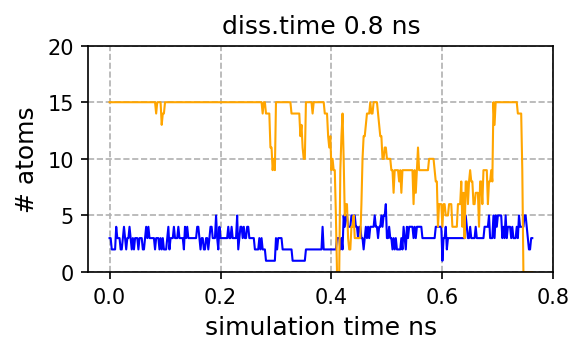

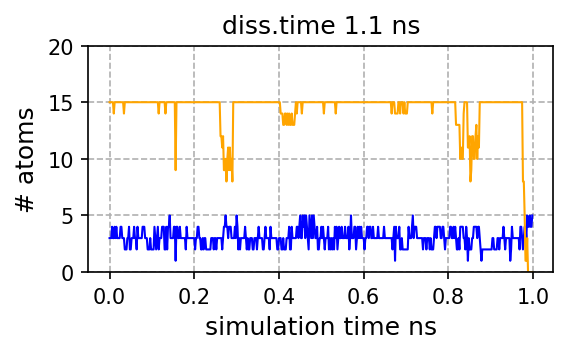

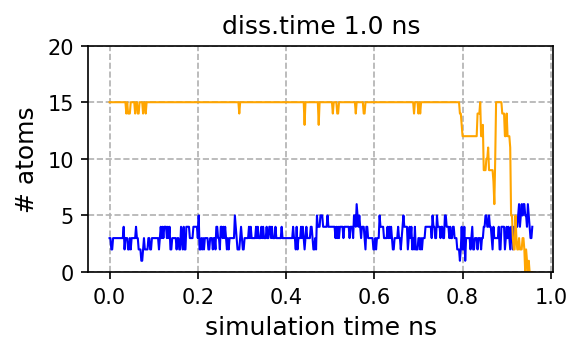

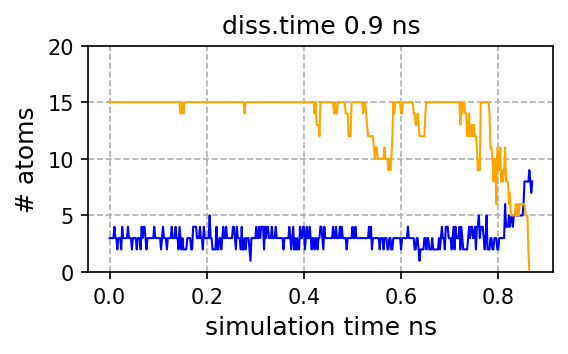

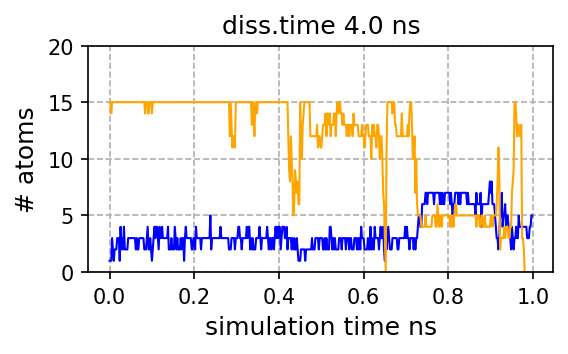

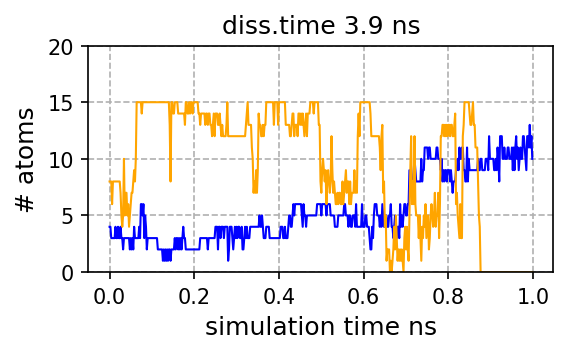

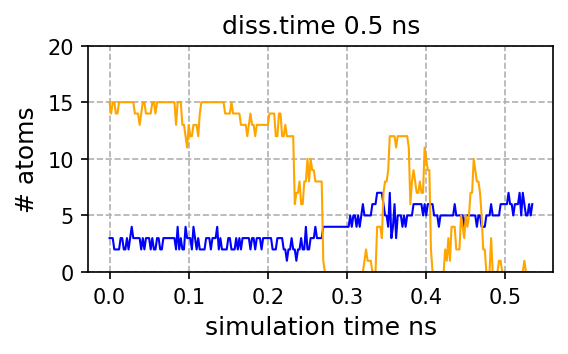

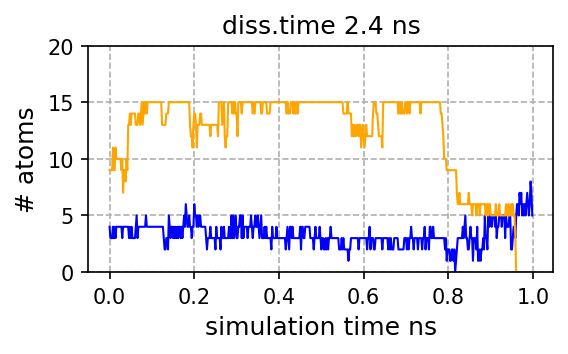

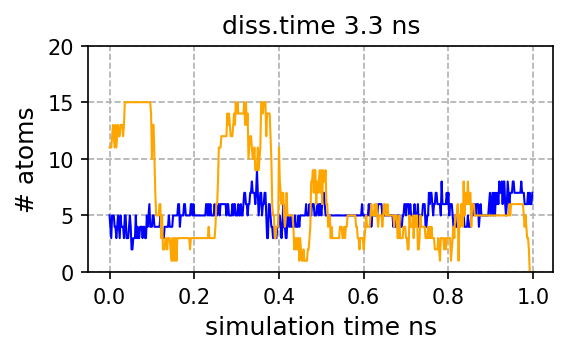

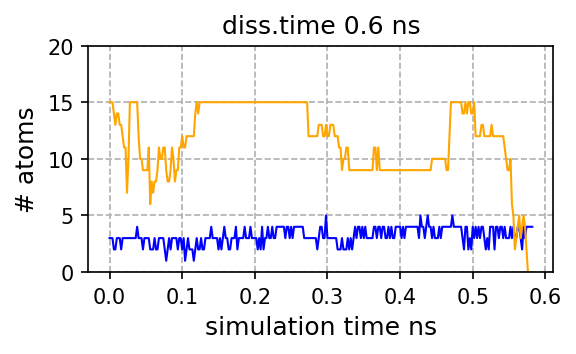

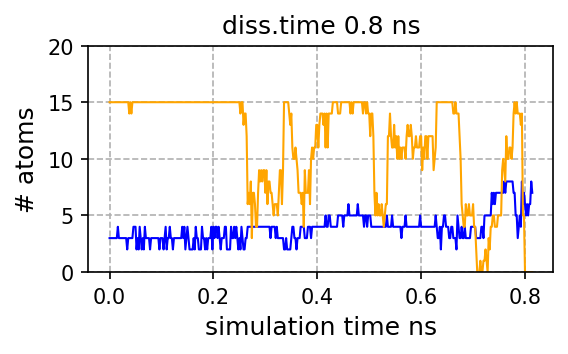

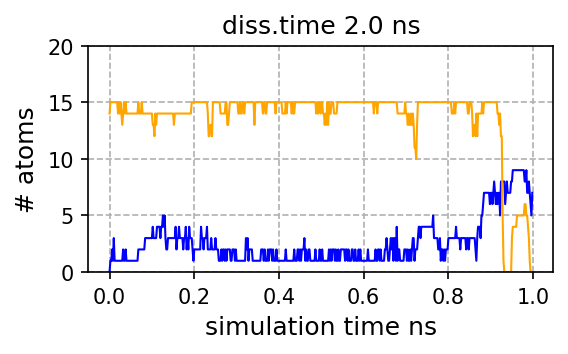

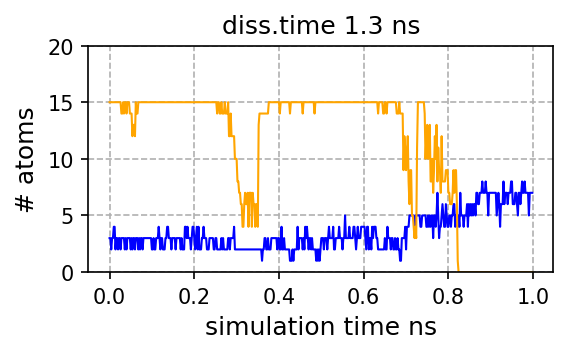

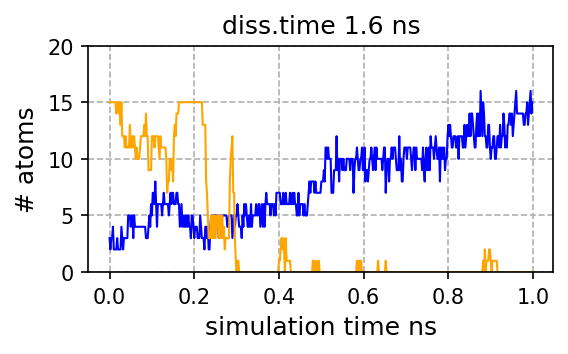

In [26]:
if AR:
    #protein solvation
    top = cm.get_cmap('Oranges_r', 128)
    bottom = cm.get_cmap('Blues', 128)
    color = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
    #fig = plt.figure(figsize=(6, 3),dpi=150)

    wat_cav = pd.read_table("DATA/GPCR-09-2020/WATER/water-1000_FAST.dat",index_col=False,sep = '\s+',header=None) # 2-water, 3-ligand
    diss_length = []
    water_length = []
    salt_length = []
    hydro_length = []
    for i,fi in enumerate(np.unique(wat_cav[0].values)):
        wat_traj = wat_cav[wat_cav[0] == fi]
        if (np.mean(wat_traj[3].values[-2:]) < 3 and wat_traj[3].values[0] > 5):
            diss_length.append(wat_traj[3][wat_traj[3].values < 2].shape[0])
            water_length.append(np.mean(wat_traj[2].values[-20:])-np.mean(wat_traj[2].values[:50]))
            salt_length.append(wat_traj[4][wat_traj[4].values > 5].shape[0])
            hydro_length.append(wat_traj[5][wat_traj[5].values > 6].shape[0])
            if (np.mean(wat_traj[2].values[-10:]) > 1*np.mean(wat_traj[2].values[:10])): #\
#                                                           and (np.max(wat_traj[5].values[:50])< 20) and (np.max(wat_traj[4].values[:50])< 20) :   
                fig = plt.figure(figsize=(4,2),dpi=150)
                fig.subplots_adjust(hspace=0.05, wspace=0.2)
                ax1 = plt.subplot(1,1,1)
                ax1.plot(wat_traj[1].values/1000.,wat_traj[2].values,color = "b",  lw=1,alpha=1,ms=2,label="water")
                ax1.plot(wat_traj[1].values/1000.,wat_traj[3].values,color = "orange",lw=1,alpha=1,ms=2,label="ligand")
                plt.grid(linestyle="--")
                ax1.set_ylim(0,20)
                plt.title("diss.time "+str(round(wat_traj[6].values[0]/1000.0,1))+" ns")
                """
                ax2 = plt.subplot(1,2,2)
                ax2.plot(wat_traj[1].values,wat_traj[4].values,color = "black", alpha=1, lw=1,ms=1, label="K-D")
                ax2.plot(wat_traj[1].values,wat_traj[5].values,color = "firebrick", alpha=1, lw=1,ms=1,label="Y-F")
                plt.yticks(range(0,20,5),fontsize=12) 
                plt.grid(linestyle="--")
                plt.ylim(0,12)
                """
                ax1.set_ylabel('# atoms',fontsize=12)
                plt.xlabel('simulation time ns',fontsize=12)
                plt.title("diss.time "+str(round(wat_traj[6].values[0]/1000.0,1))+" ns")
                plt.show()



#  5. Hierarchical clustering of the last P-L contact  (or finding main  egress routs)

## 5.1 Collection of the pre-dissociation frames for clustering

[]

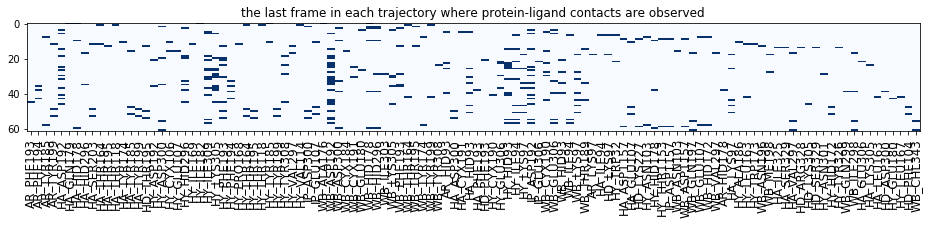

In [27]:
##########################
# collection of the pre-dissociation frames for clustering
# pre-dissociation frame - the last frame where more than 3 (parameter contacts) IFP values are non-zero
##########################
def last_frames_by_contact(df_tot,columns_IFP,contacts=3):
    r_t_f = []
    com_tot = []
    diss = []
    for r in df_tot.Repl.unique():  
        df_repl = df_tot[df_tot.Repl == r]
        for t in df_repl.Traj.unique():
 #           print(r,t)
            df_traj = df_repl[df_repl.Traj == t]
            sum_IFP = df_traj[columns_IFP].sum(1).values
            last_frame = np.max(np.argwhere(sum_IFP > contacts))
            r_t_f.append((r,t,last_frame))
            
    df = pd.DataFrame(columns = df_tot.columns)        
    for (r,t,f) in r_t_f:  
        df_repl = df_tot[df_tot.Repl == r]
        df_traj = df_repl[df_repl.Traj == t]
        df = df.append(df_traj[df_traj.time == f], ignore_index = True)
        com_tot.append(df_traj[df_traj.time == f][["COM_x","COM_y","COM_z"]].values)
        diss.append(df_traj[df_traj.time == f]["length"].values)
    ar = df[columns_IFP].values
    return(ar,r_t_f,df,np.asarray(com_tot),np.asarray(diss))
     
ifp_list = ["AR","HD","HA","HY","WB","IP","IN"]
#ifp_list = ["RE"]
columns_IFP = []  # standard IFP
for c in df_tot.columns.tolist():
    if c[0:2] in ifp_list: columns_IFP.append(c)

#--------------- cluster by the last frame IFP
ar,r_t_f,df,com,time = last_frames_by_contact(df_tot,columns_IFP,4)
ar_nonzero = ar[:,(np.array(ar).sum(0) > 0)]  # remove empty columns
columns_IFP_nonzero = np.asarray(columns_IFP)[np.argwhere((np.array(ar).sum(0)>0)).flatten()]
#print(ar.shape,ar_nonzero.shape,ar_nonzero.sum(0),columns_IFP_nonzero)


fig = plt.figure(figsize = (16,2),facecolor='w')
plt.imshow(ar_nonzero.astype(float),cmap='Blues',aspect = "auto")
plt.xticks(range(0,len(columns_IFP_nonzero)),columns_IFP_nonzero,rotation=90,fontsize=12)
plt.title("the last frame in each trajectory where protein-ligand contacts are observed")
plt.plot()


## 15.2 Clustering of egress routs


1 5 ['AR_TYR199' 'HA_SER203' 'HA_THR164' 'HA_THR118' 'HA_TYR199' 'HY_ILE169'
 'HY_PRO168' 'HY_THR164' 'HY_THR118' 'HY_TYR199' 'HY_VAL114' 'WB_THR164'
 'WB_TYR199' 'HY_LEU163' 'HY_TRP173' 'HA_LEU163' 'HY_LEU167']
1 ............... 5 [  4.816   8.707   7.961 702.     26.284]
Residence time: 1 5 13.860459919839679
2 2 ['HA_ASP1157' 'HD_LYS227' 'HY_THR1153' 'IP_ASP1157' 'WB_ASP1157']
2 ............... 2 [7.893 7.893]
3 2 ['AR_TYR185' 'WB_TYR174' 'HY_ASN103' 'WB_GLU107' 'WB_HID172']
3 ............... 2 [4.903 4.903]
4 1 ['HA_ILE325' 'HA_SER329' 'HD_ARG328' 'HD_SER329' 'HY_TYR326']
5 37 ['AR_PHE193' 'AR_PHE194' 'HA_ASP192' 'HA_HID296' 'HD_THR195' 'HY_ASP192'
 'HY_ASP300' 'HY_HID296' 'HY_ILE309' 'HY_LYS305' 'HY_PHE193' 'HY_PHE194'
 'HY_THR195' 'HY_TYR308' 'IP_ASP300' 'WB_ASP192' 'WB_ASP300' 'WB_CYX191'
 'WB_GLU180' 'WB_LYS305' 'WB_PHE193' 'WB_TYR308' 'AR_HID93' 'HA_ASP300'
 'HA_CYX191' 'HA_HID93' 'HA_PHE193' 'HD_PHE193' 'HY_CYX190' 'HY_GLU306'
 'HY_HID93' 'HY_ILE94' 'HY_LYS97' 'IP_ASP192' 'IP

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([ 5,  2,  2,  1, 37, 11,  4], dtype=int64))

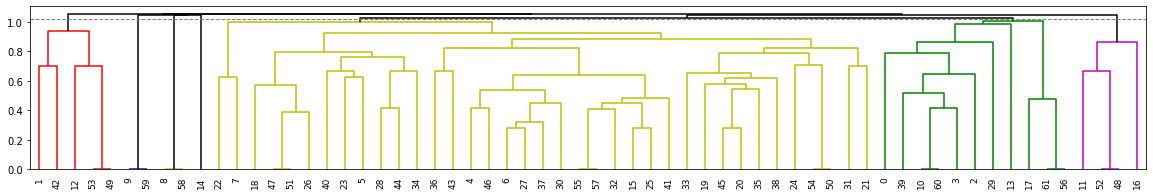

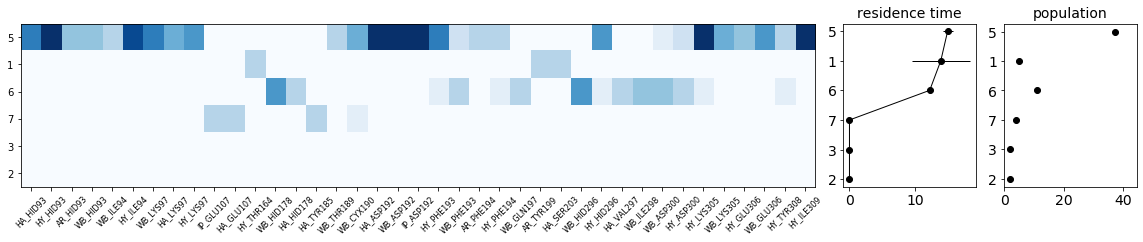

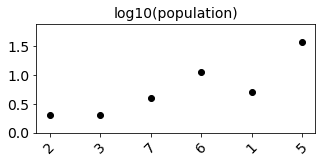

In [28]:
from scipy.cluster import hierarchy
#######################
# estimation of the residence time for each cluster 
#
####################
def bootstrapp(t):
    max_shuffle = 500
    alpha = 0.9
    sub_set = int(alpha*len(t))        
    tau_bootstr = []
    if sub_set > 3: #( if the sub_set size is above 3, otherwise bootstrapping  does not make sense)
        for i in range(1,max_shuffle):
            numpy.random.shuffle(t)
            t_b = t[:sub_set]
            t_b_sorted_50 = (np.sort(t_b)[int(len(t_b)/2.0-0.5)]+np.sort(t_b)[int(len(t_b)/2)])/2.0
            tau_bootstr.append(t_b_sorted_50)
    return(tau_bootstr)


X = ar_nonzero.astype(float)

Z= linkage(X, method = 'average', metric='correlation', optimal_ordering=True)
threshold =1.02

plt.figure(figsize=(20,3))
plt.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
hierarchy.set_link_color_palette(['r', 'b', 'orange', 'y', 'green', 'm','gray'])
den = dendrogram(Z, 0.25, color_threshold=threshold, above_threshold_color='k', leaf_font_size=9)

plt.savefig(DIR_out+"dendagram-ifp.png",dpi=300)    
 
clusters = clust.fcluster(Z,threshold, criterion='distance')

cl, count = np.unique(clusters,return_counts=True )
t_cluster = []
t_std_cluster = []
ifps_cluster = []
count_cluster = []
cl_cluster = []

# estimate residence time and population for each cluster 
for k,c in zip(cl,count):
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    ifps_mean = np.mean(X[ind,:],axis=0)
    print(k,c, columns_IFP_nonzero[np.argwhere(ifps_mean > 0)].flatten())
    if c > 1:
        print(k,"...............",c,time[ind].flatten())
        tb = np.asarray(bootstrapp(time[ind].flatten()))
        if (len(tb) > 0):
            t_cluster.append(np.mean(tb))
            t_std_cluster.append(np.std(tb))
        else:
            t_cluster.append(0)
            t_std_cluster.append(0)
        cl_cluster.append(k)
        count_cluster.append(c)
        ifps_cluster.append(np.sum(ar_nonzero.astype(float)[ind,:],axis=0))
        if(t_cluster[-1] > 0): print("Residence time:",k,c,t_cluster[-1])

# order clusters by the decrease of the  residence time           
count_cluster = np.array(count_cluster)
cl_cluster = np.array(cl_cluster)
t_cluster = np.array(t_cluster)
t_std_cluster = np.array(t_std_cluster)
index_tau = np.argsort(t_cluster)

#select IFP to show
index = []
for a in columns_IFP_nonzero:
    index.append(int(a[6:]))
index = np.argsort(index)
ifp_subset_large = (np.max(np.asarray(ifps_cluster)[index_tau][:,index],axis=0) > 2)

index = index[ifp_subset_large]
fig = plt.figure(figsize = (20,3),facecolor='w') 
gs = gridspec.GridSpec(1,3, width_ratios=[6, 1,1],wspace=0.08) 


ax = plt.subplot(gs[0])
ax.imshow(np.asarray(ifps_cluster)[np.flip(index_tau)][:,index],cmap='Blues',aspect = "auto",vmin=0, vmax=10)
plt.yticks(range(0,cl_cluster[np.flip(index_tau)].shape[0]),cl_cluster[np.flip(index_tau)],fontsize=10)
plt.xticks(range(0,len(columns_IFP_nonzero[index])),columns_IFP_nonzero[index],rotation=45,fontsize=8)
#---------- plot residence times in clusters
ax = plt.subplot(gs[1])
ax.errorbar(y=range(0,len(t_cluster[index_tau])),x=t_cluster[index_tau],xerr=t_std_cluster[index_tau],color = 'k', marker='o',lw=1)
plt.yticks(range(0,len(cl_cluster[index_tau])),cl_cluster[index_tau],fontsize=14)
#plt.xlim((0.2,1.2*max(t_cluster)))
plt.xticks(fontsize=14)
plt.title("residence time",fontsize=14)
print("res.times ",t_cluster)
#plt.ylim((1,len(t_cluster)+1))
#--------------- plot cluster population
ax = plt.subplot(gs[2])
ax.scatter(y=range(0,len(t_cluster[index_tau])),x=count_cluster[index_tau],color = 'k')
#plt.yticks(range(0,np.max(cl_cluster)),np.flip(cl_cluster),fontsize=14)
plt.yticks(range(0,len(cl_cluster[index_tau])),cl_cluster[index_tau],fontsize=14)
plt.xticks(fontsize=14)
plt.xlim((0,1.2*np.max(count_cluster)))
plt.title("population",fontsize=14)
#plt.ylim((1,np.max(cl)))
plt.savefig(DIR_out+"clusters-ifp.png",dpi=300,bbox_inches = 'tight')    
 
    
fig = plt.figure(figsize = (5,2),facecolor='w') 
plt.scatter(y=np.log10(count_cluster[index_tau]),x=range(0,len(t_cluster[index_tau])),color = 'k')
plt.xticks(range(0,len(cl_cluster[index_tau])),cl_cluster[index_tau],fontsize=14,rotation = 45)
plt.yticks(fontsize=14)
plt.ylim((0,1.2*np.max(np.log10(count_cluster))))
plt.title("log10(population)",fontsize=14)
print(df.ligand.unique())

print("Res.times:", t_cluster,"re-ordrred:",t_cluster[index_tau])
print("Population:", count_cluster,"re-ordrred:",count_cluster[index_tau])
cl, count

## 5.3 Visualization of all trajectories, whose frames belong to particular cluster - 3D grid

In [34]:
print("Cluster numbers:",cl)
print("Cluster populations:",count)
for k in cl[count>1]:
    print("save cluster ",k)
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    channel = np.asarray(r_t_f)[ind]
    for i,ch in enumerate(channel):
        d = df_tot[(df_tot.Repl == ch[0]) & (df_tot.Traj == ch[1])] # & (df_tot.time == int(ch[2]))]
        if i == 0: d_channel = d
        else: d_channel = pd.concat([d_channel,d])
    if(i > 1):
        #print(channel)
        Map_3D_grid( d_channel,DIR_out+"densityFV1-"+"-"+str(int(threshold*10))+"-"+version+str(k)+".dx")

Cluster numbers: [1 2 3 4 5 6 7]
Cluster populations: [ 5  2  2  1 37 11  4]
save cluster  1
save cluster  2
save cluster  3
save cluster  5
save cluster  6
save cluster  7
